# Deep Hedging of Green PPAs

In [1]:
import datetime as dt
import sys
sys.path.insert(0,'../..')
from typing import List
import numpy as np
import matplotlib.pyplot as plt
import json
import os
import numpy as np
from scipy.special import comb
import pandas as pd
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

from rivapy.tools.datetime_grid import DateTimeGrid
from rivapy.models.residual_demand_fwd_model import WindPowerForecastModel, MultiRegionWindForecastModel, LinearDemandForwardModel
from rivapy.instruments.ppa_specification import GreenPPASpecification
from rivapy.models.residual_demand_model import SmoothstepSupplyCurve
from rivapy.models import OrnsteinUhlenbeck
from rivapy.pricing.green_ppa_pricing import GreenPPADeepHedgingPricer, DeepHedgeModel

import analysis

from IPython.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

%load_ext autoreload
%autoreload 2
%matplotlib inline

/home/doeltz/doeltz/development/RiVaPy/sandbox/green_ppa/../../rivapy/__init__.py:11: UserWarning: The pyvacon module is not available. You may not use all functionality without this module. Consider installing pyvacon.
  warnings.warn('The pyvacon module is not available. You may not use all functionality without this module. Consider installing pyvacon.')
2023-08-30 08:16:16.015446: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-08-30 08:16:16.015508: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


# Residual Demand Forward Model

In [4]:
days = 2
timegrid = np.linspace(0.0, days*1.0/365.0, days*24)
forward_expiries = [timegrid[-1]]

In [5]:
wind_onshore = WindPowerForecastModel(region='Onshore', speed_of_mean_reversion=2.0, volatility=4.0)
wind_offshore = WindPowerForecastModel(region='Offshore', speed_of_mean_reversion=2.0, volatility=3.0)
regions = [ MultiRegionWindForecastModel.Region( 
                                    wind_onshore,
                                    capacity=1000.0,
                                    rnd_weights=[0.8,0.2]
                                ),
           MultiRegionWindForecastModel.Region( 
                                    wind_offshore,
                                    capacity=100.0,
                                    rnd_weights=[0.2,0.8]
                                )
           
          ]
wind = MultiRegionWindForecastModel('Wind_Germany', regions)

model = LinearDemandForwardModel(wind_power_forecast=wind, 
                                 x_volatility = 4.0 , 
                                 x_mean_reversion_speed = 0.1,
                                 power_name= 'Power_Germany')

In [8]:
np.random.seed(42)
rnd = np.random.normal(size=model.rnd_shape(n_sims=10_000, n_timesteps=timegrid.shape[0]))
paths = model.simulate(timegrid, rnd, expiries=forward_expiries, 
                                 initial_forecasts={'Onshore': [0.95],
                                                          'Offshore': [0.6]},
                                power_fwd_prices = [1.0])

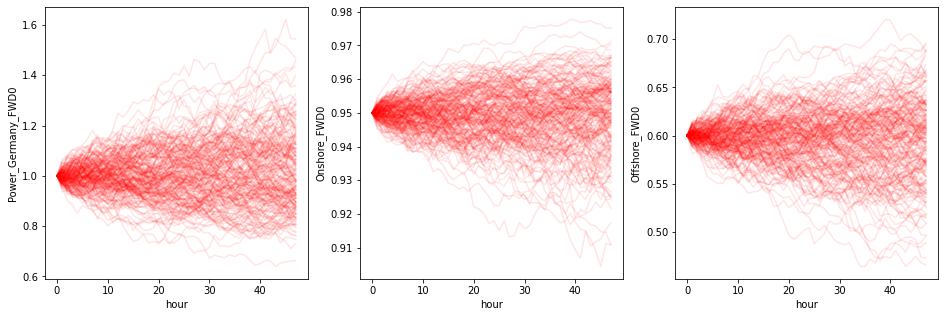

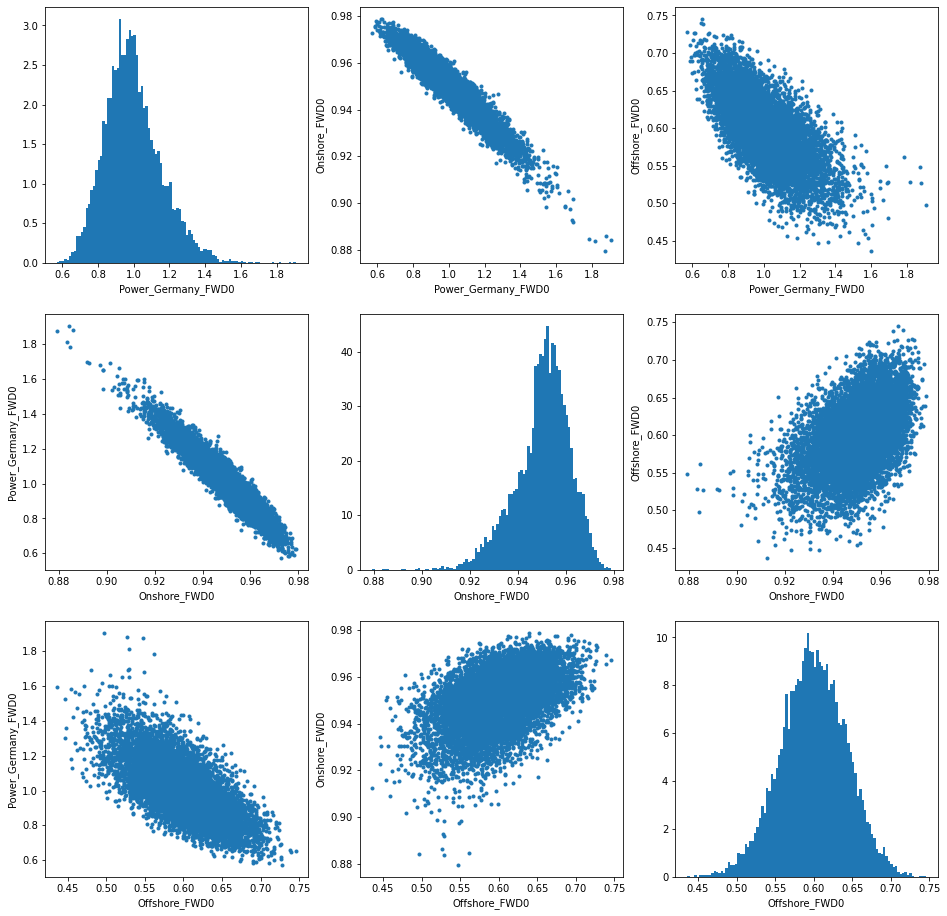

In [9]:
analysis.plot_paths(paths, None)

In [15]:
paths.get('Power_Germany_FWD0')[-1].mean()

0.9957418411935248

# Experiments

In [16]:
val_date = dt.datetime(2023,1,1)
strike = 1.0 #0.22
spec = GreenPPASpecification(udl='Power_Germany',
                            technology = 'Wind',
                             location = 'Onshore',
                             schedule = [val_date + dt.timedelta(days=2)], 
                             fixed_price=strike,
                             max_capacity = 1.0)

In [10]:
repo = analysis.Repo('./experiments/')

In [8]:
repo.results.keys()

dict_keys([])

In [20]:
pricing_results = repo.run(val_date, 
                           spec, model, 
                           initial_forecasts={'Onshore': [0.8],
                                        'Offshore': [0.6]},
                           power_fwd_prices=[1.0],
                           forecast_hours=[10, 14, 18],
                           additional_states=['Offshore'],
                           depth=3, 
                           nb_neurons=64, 
                           n_sims=100_000, 
                           regularization=0.0,
                           epochs=1, verbose=1,
                           tensorboard_logdir = 'logs/' + dt.datetime.now().strftime("%Y%m%dT%H%M%S"), 
                           initial_lr=5e-4,
                           decay_steps=8_000,
                           batch_size=100, decay_rate=0.8, seed=42)

/home/doeltz/doeltz/development/RiVaPy/sandbox/green_ppa/../../rivapy/tools/datetime_grid.py:24: FutureWarning: Argument `closed` is deprecated in favor of `inclusive`.
  self.dates = pd.date_range(start, end, freq=freq, tz=tz, closed=closed).to_pydatetime()


3125/3125 [==============================] - 5s 1ms/step - loss: 2.0589e-05


2023-07-27 10:34:48.346564: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: ./experiments//2249948d0aadb13eb2d31acef838145b44f11b01//delta_model/assets


INFO:tensorflow:Assets written to: ./experiments//2249948d0aadb13eb2d31acef838145b44f11b01//delta_model/assets


# Analysis

In [2]:
repo = analysis.Repo('./experiments/')
# TODO: das muss wieder weg und in die serialisierung
for k,v in repo.results.items():
    v['val_date'] = dt.datetime.fromisoformat(v['val_date'])
    v['ppa_spec']['schedule'] = [dt.datetime.fromisoformat(k) for k in v['ppa_spec']['schedule']]

## HiPlot

In [38]:
repo.plot_hiplot()

<IPython.core.display.Javascript object>

In [29]:
experiments = {}
# models with different regularization coefficients, n_forecast_hours = 3
tmp = {
'ref_keys': [ 
                #'c977969a206844c4a79848df3db0ccd09bcd8ee7',
                 #'1aedf203216342f2dea183af9fcdda341e31337a', 
                '417bfb85f4dba1ff37f76ff7d5fdb6ca2e0d2ea8',
                'c679f5903b066db828d211ea1c48f03395f76d21', 
                'e351f639d6c035c0a4cfeff4dd3ebd43d39f9932'
               ],
    'labels': {'417bfb85f4dba1ff37f76ff7d5fdb6ca2e0d2ea8': '0.0', 
              '1aedf203216342f2dea183af9fcdda341e31337a': '0.1', 
              'c977969a206844c4a79848df3db0ccd09bcd8ee7': '0.25', 
              'c679f5903b066db828d211ea1c48f03395f76d21': '0.5', 
              'e351f639d6c035c0a4cfeff4dd3ebd43d39f9932': '1.0'},
    'description':'varying regularization term for problem with three forecast hours [10,14,18]',
}
experiments['varying_regularization']=tmp
experiments['zero_wind_volatility'] ={'ref_keys': ['489bf539cf645622b5a1fa29392a68e895b84f5b'], 
                                      'labels':{'489bf539cf645622b5a1fa29392a68e895b84f5b':'0.0'}, 
                                      'description':'zero wind wolatility (perfect replication by static hedge)'
                                     }

experiments['strikes'] = { 'ref_keys': ['9c8b7a3a50ad27fc9be89c9324c074cebb86b4a9',  '417bfb85f4dba1ff37f76ff7d5fdb6ca2e0d2ea8', '1daab358760e5f2dbf34bc6600ba41ae02020493'],
                         'labels': {'9c8b7a3a50ad27fc9be89c9324c074cebb86b4a9':'0.9', 
                                  '417bfb85f4dba1ff37f76ff7d5fdb6ca2e0d2ea8':'1.0',
                                   '1daab358760e5f2dbf34bc6600ba41ae02020493': '1.1'},                          
                              'description':'different strikes'     }

experiments['forecasts'] ={'ref_keys':['7525471af6019d720fe596c36a689a8bcbaf6c3b', 
                                       '21b26f95807cefd400cd467b94b890f17e729395',
                                      '417bfb85f4dba1ff37f76ff7d5fdb6ca2e0d2ea8',
                                      '643e9896e2240d5815bbb9c9520215ae766a3447'], 
                           'labels':{'7525471af6019d720fe596c36a689a8bcbaf6c3b':'0.2', 
                                    '21b26f95807cefd400cd467b94b890f17e729395':'0.5',
                                    '417bfb85f4dba1ff37f76ff7d5fdb6ca2e0d2ea8':'0.8',
                                     '643e9896e2240d5815bbb9c9520215ae766a3447':'0.9'
                                    }}
if False:
    ref_keys = [ 'dccace069db421847b1383ffbef87420f59ea572',
                '1dd54ac29bc57e78554ac5c30edf5bf24574fddf'
               ]
    labels = {'dccace069db421847b1383ffbef87420f59ea572':'0.0',
              '1dd54ac29bc57e78554ac5c30edf5bf24574fddf': '0.1'
    }

In [30]:
experiment = 'forecasts' #'zero_wind_volatility', 'varying_regularization'
ref_keys = experiments[experiment]['ref_keys']
labels = experiments[experiment]['labels']
hedge_models = {k: repo.get_hedge_model(k) for k in ref_keys}
specs = {k: GreenPPASpecification.from_dict(repo.results[k]['ppa_spec']) for k in ref_keys}
result_dir = 'results/'+experiment+'/'

## Model paths

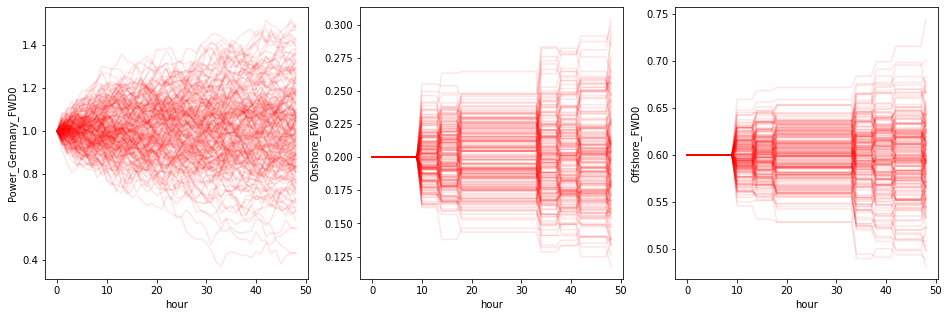

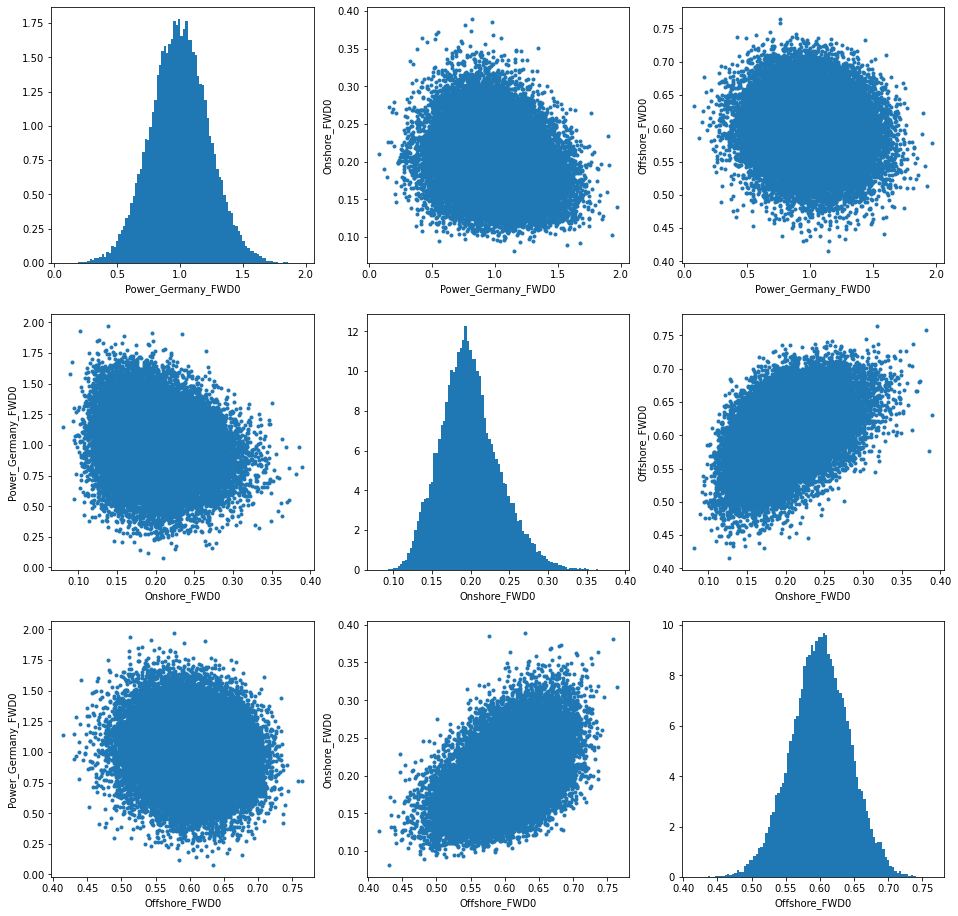

In [31]:
sim_results ={}
forecast_points={}
for k in ref_keys:
    sim_results[k], forecast_points[k] = repo.simulate_model(k, n_sims=40_000)
    
analysis.plot_paths(sim_results[ref_keys[0]], forecast_points[ref_keys[0]], result_dir)

## Hedge PnL

In [32]:
def compute_pnl(hedge_model, paths, green_ppa_spec):
    power_price = paths.get('Power_Germany_FWD0', None)
    volume = paths.get(green_ppa_spec.location+'_FWD0')
    print(green_ppa_spec.fixed_price)
    payoff = (power_price[-1,:] -green_ppa_spec.fixed_price)*(volume[-1,:])
    return hedge_model.compute_pnl(paths, payoff)

def compute_volume_hedge_pnl(paths, green_ppa_spec):
    power_price = paths.get('Power_Germany_FWD0', None)
    volume = paths.get(green_ppa_spec.location+'_FWD0')
    pnl = volume[0,:]*power_price[0,:]
    for i in range(1,power_price.shape[0]-1):
        pnl += (volume[i,:]-volume[i-1,:])*power_price[i,:]
    pnl -= volume[-2,:]*power_price[-1,:]
    pnl += (power_price[-1,:] -green_ppa_spec.fixed_price)*(volume[-1,:])
    return pnl

def compute_no_hedge_pnl(paths, green_ppa_spec):
    power_price = paths.get('Power_Germany_FWD0', None)
    volume = paths.get(green_ppa_spec.location+'_FWD0')
    pnl = (power_price[-1,:] -green_ppa_spec.fixed_price)*(volume[-1,:])
    return pnl


def compute_static_volume_hedge_pnl(paths, green_ppa_spec):
    power_price = paths.get('Power_Germany_FWD0', None)
    volume = paths.get(green_ppa_spec.location+'_FWD0')
    pnl = (power_price[-1,:] -green_ppa_spec.fixed_price)*(volume[-1,:]) + (-power_price[-1,:] +power_price[0,:])*(volume[0,:])
    return pnl

In [33]:
paths = {k:{l:sim_results[k].get(l, forecast_points[k]) for l in ['Power_Germany_FWD0', 'Onshore_FWD0', 'Offshore_FWD0']} for k in ref_keys}
pnl = {
    'pnl_volume_hedge': compute_volume_hedge_pnl(paths[ref_keys[0]], specs[ref_keys[0]]),
      #'pnl_no_hedge': compute_no_hedge_pnl(paths, spec)
      }
for k,v in hedge_models.items():
    pnl[labels[k]] = compute_pnl(v, paths[k], specs[k])#specs['ec202973a34dfc5b71a86e0e7b2209a62c29b6a1'])#
#pnl['pnl_static_volume_hedge']= compute_static_volume_hedge_pnl(paths, spec)

1.0
1.0
1.0
1.0


In [10]:
#del pnl['pnl_static_volume_hedge']
#del pnl['1.0']
del pnl['pnl_volume_hedge']

### Distribution

FileNotFoundError: [Errno 2] No such file or directory: 'results/forecasts/pnl_distributions.png'

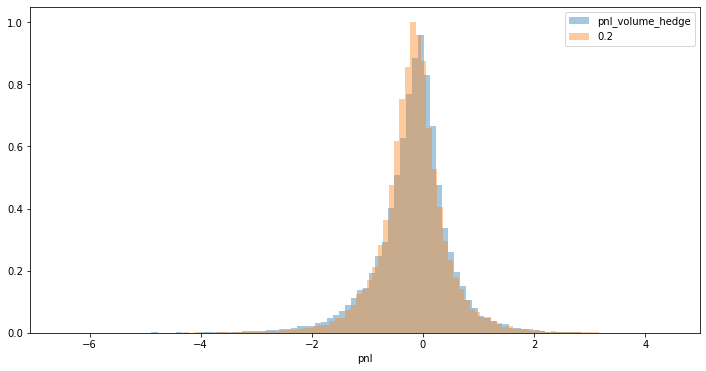

In [13]:
plt.figure(figsize=(12,6))
alpha = 0.4#1.0/len(pnl)
#plt.hist(pnl_volume_hedge,bins=100, label='volume hedge', alpha=alpha, density=True)

order = []
for k,v in pnl.items():
    order.append((np.var(v),k))
    
order.sort(reverse=True)
order = [k[1] for k in order]
for k in order:
    pnl_=pnl[k]#p.minimum(np.maximum(pnl[k],-0.05),0.02)
    plt.hist(100*pnl_,bins=100, label=k, alpha=alpha, density=True)
plt.legend()
#plt.xlim(-10.0,4.0)
plt.xlabel('pnl');
plt.savefig(result_dir+'pnl_distributions.png', dpi=400)

### Statistics

In [19]:
pnl_stat = {'name':[], 'mean': [], 'var':[], '1%': [], '5%':[]}
for k,v in pnl.items():
    pnl_stat['name'].append(k)
    pnl_stat['mean'].append(np.mean(100.0*v))
    pnl_stat['var'].append(np.var(100.0*v))
    pnl_stat['1%'].append(np.percentile(100.0*v, 1))
    pnl_stat['5%'].append(np.percentile(100.0*v, 5))
pd.DataFrame(pnl_stat)

,name,mean,var,1%,5%
0,pnl_volume_hedge,-0.181050,0.471991,-2.373298,-1.344422
1,0.2,-0.180413,0.389495,-2.000797,-1.171137


### Dependencies

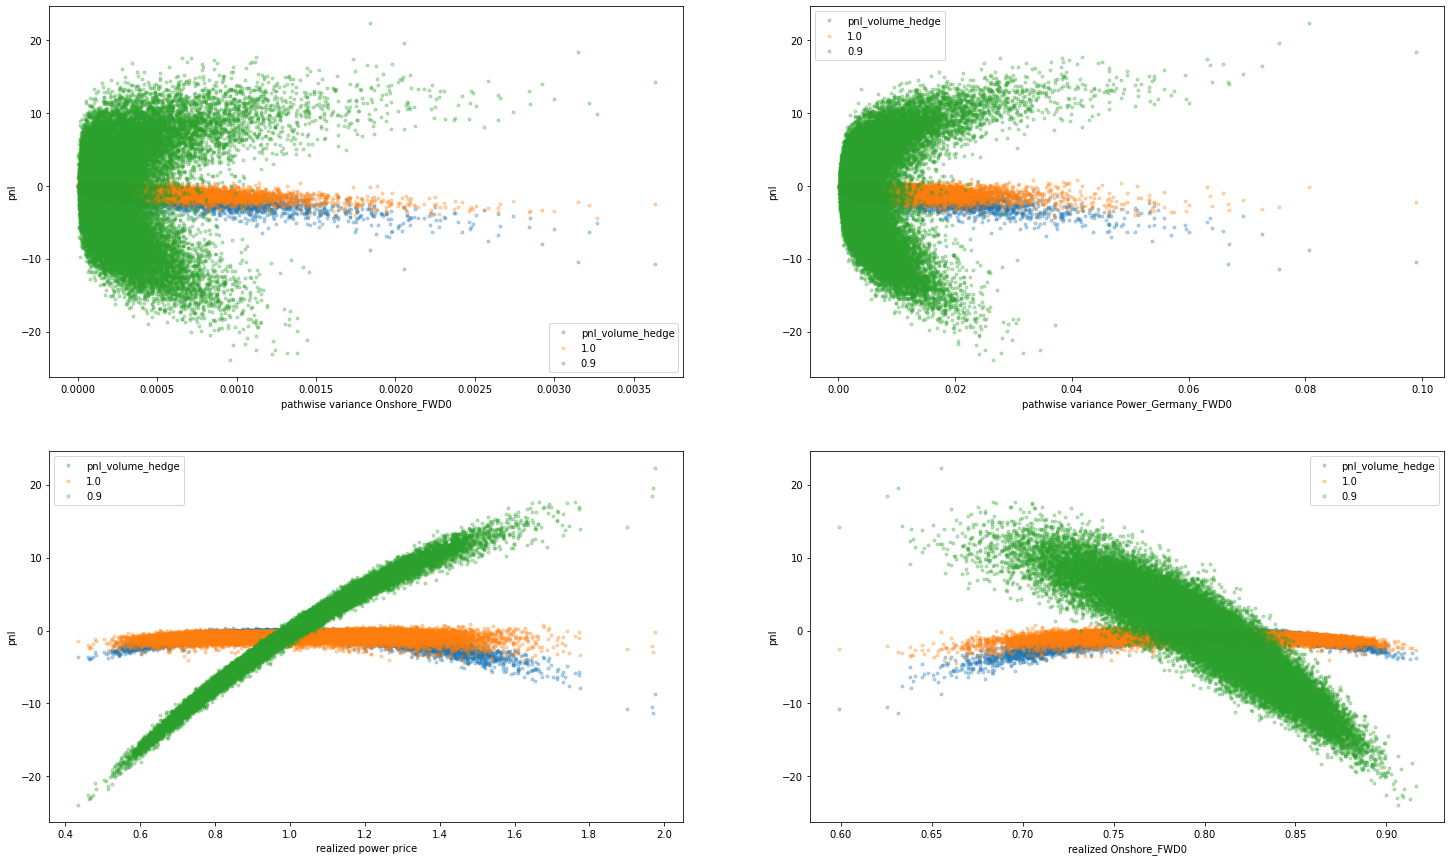

In [80]:
plt.figure(figsize=(25,15))

power_price = paths.get('Power_Germany_FWD0', None)
volume = paths.get(spec.location+'_FWD0')
volume_var = volume.var(axis=0)
plt.subplot(2,2,1)
#plt.hist(volume_var, bins=100, density=True);
for k,v in pnl.items():
    if k == '0.5':
        continue
    plt.plot(volume_var, 100.0*v, '.', alpha=0.3, label=k)
plt.legend()
plt.ylabel('pnl')
plt.xlabel('pathwise variance Onshore_FWD0')

plt.subplot(2,2,2)
power_var = power_price.var(axis=0)
#plt.hist(volume_var, bins=100, density=True);
for k,v in pnl.items():
    if k == '0.5':
        continue
    plt.plot(power_var, 100.0*v, '.', alpha=0.3, label=k)
plt.legend()
plt.ylabel('pnl')
plt.xlabel('pathwise variance Power_Germany_FWD0');

plt.subplot(2,2,3)
for k,v in pnl.items():
    if k == '0.5':
        continue
    plt.plot(power_price[-1,:], 100.0*v, '.', alpha=0.3, label=k)
plt.legend()
plt.ylabel('pnl')
plt.xlabel('realized power price');

plt.subplot(2,2,4)
for k,v in pnl.items():
    if k == '0.5':
        continue
    plt.plot(volume[-1,:], 100.0*v, '.', alpha=0.3, label=k)
plt.legend()
plt.ylabel('pnl')
plt.xlabel('realized Onshore_FWD0');
plt.savefig(result_dir+'pnl_vs_paths.png', dpi=400)

In [15]:
hedge_models.items()

dict_items([('7525471af6019d720fe596c36a689a8bcbaf6c3b', <rivapy.pricing.deep_hedging.DeepHedgeModel object at 0x7f3992178d00>)])

## Delta Plots

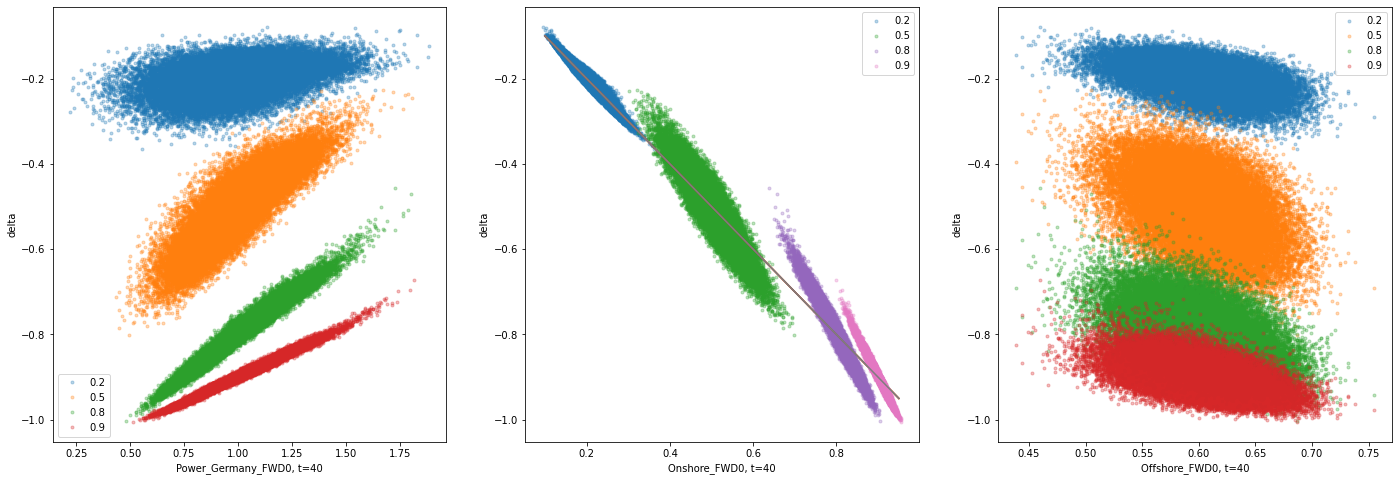

In [37]:
t = 40
n_x = 1
n_y = 3
plt.figure(figsize=(24,8))

volume_hedge=-1.0*paths[ref_keys[0]]['Onshore_FWD0'][t,:]
plot_volume_hedge = True
for key, hedge_model in hedge_models.items():
    #plt.figure(figsize=(24,8))
    #if labels[key] in ['1.0','0.5']:
    #    continue
    delta = hedge_model.compute_delta(paths[key], t)
    i=1
    
    for k,v in paths[key].items():
        plt.subplot(n_x, n_y, i)
        plt.plot(v[t,:], delta,'.', label=labels[key], alpha=0.3)
        #if plot_volume_hedge and True:
        #    plt.plot(v[t,:], volume_hedge, '.', label='volume hedge', alpha=0.3)
        if k == 'Onshore_FWD0':
            plt.plot([0.1,0.95],[-0.1,-0.95])
        plt.xlabel(k+', t='+str(t))
        plt.ylabel('delta')
        plt.legend()
        i+= 1
    plot_volume_hedge = False
    
plt.legend()
plt.savefig(result_dir+'delta_'+str(t)+'.png', dpi=400)
if False:
    for k,v in paths.items():
        plt.subplot(n_x, n_y, i)
        plt.plot(v[t,:], v[-1,:],'.')
        plt.xlabel(k+', t='+str(t))
        plt.ylabel(k+', final')
        i+= 1

In [40]:
delta = {'volume hedge': -paths.get('Onshore_FWD0')}
for key, hedge_model in hedge_models.items():
    d = hedge_model.compute_delta(paths)
    delta[labels[key]] = d.reshape((d.shape[0],-1))

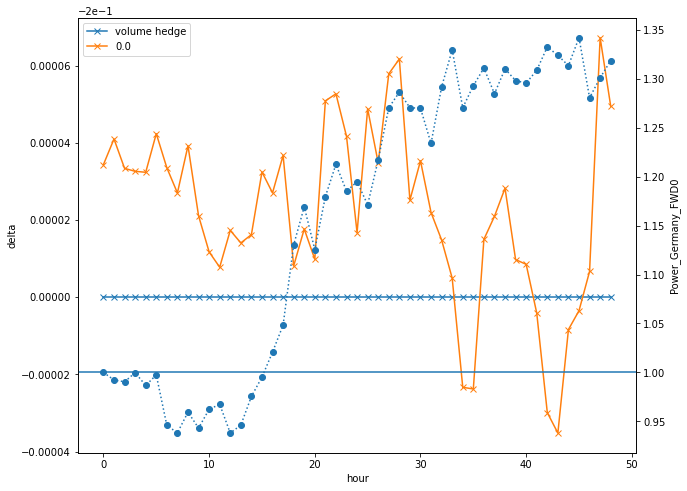

In [41]:
n_path = 5

pnl_diff = pnl['pnl_volume_hedge']-pnl['0.0']
#n_path = np.argmin(pnl_diff)

plt.figure(figsize=(10,8))
for k,v in delta.items():
    plt.plot(v[:,n_path], '-x', label=k)
plt.legend()  
plt.ylabel('delta')
plt.xlabel('hour'); 
ax2 = plt.twinx() 
power = paths.get('Power_Germany_FWD0')
ax2.plot(power[:,n_path],':o')
ax2.set_ylabel('Power_Germany_FWD0')
ax2.axhline(1.0)

5087